In [2]:
import json, os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data = os.popen('../build/tann test greedy-net ../datasets/siftsmall-128-euclidean.hdf5').read()
data = np.array(json.loads(data))

Try to read /test [I16]... --> size: 100x128
Try to read /train [I16]... --> size: 10000x128
[Linear Search]
Build time: 46 ns
Query time: 18316969 ns
[Greedy Net, shard_count=1] => build time: 1497653745 ns
[Greedy Net, shard_count=2] => build time: 763498927 ns
[Greedy Net, shard_count=3] => build time: 504095862 ns
[Greedy Net, shard_count=4] => build time: 392638596 ns
[Greedy Net, shard_count=5] => build time: 333277915 ns
[Greedy Net, shard_count=6] => build time: 295905849 ns
[Greedy Net, shard_count=7] => build time: 285999005 ns
[Greedy Net, shard_count=8] => build time: 258371659 ns
[Greedy Net, shard_count=9] => build time: 281983401 ns
[Greedy Net, shard_count=10] => build time: 267639480 ns
[Greedy Net, shard_count=11] => build time: 266912489 ns
[Greedy Net, shard_count=12] => build time: 243947821 ns
[Greedy Net, shard_count=13] => build time: 242963805 ns
[Greedy Net, shard_count=14] => build time: 247812715 ns
[Greedy Net, shard_count=15] => build time: 235267209 ns
[G

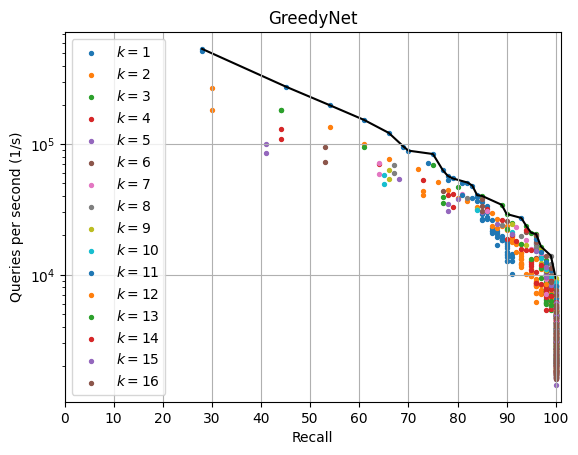

In [25]:
n = data.shape[0]
SC = data[:,0]
QPS = data[:,2]
RECALL = data[:,3]
# plt.scatter(RECALL[SC==1], QPS[SC==1], c='red', alpha=0.2, label="S=1")
# plt.scatter(RECALL[SC==2], QPS[SC==2], c='orange', alpha=0.2, label="S=2")
# plt.scatter(RECALL[SC==5], QPS[SC==5], c='blue', alpha=0.2, label="S=5")
# plt.scatter(RECALL[SC==6], QPS[SC==6], c='green', alpha=0.2, label="S=6")
# plt.scatter(RECALL[SC==7], QPS[SC==7], c='purple', alpha=0.2, label="S=7")
for i in range(1, 17):
    plt.scatter(RECALL[SC==i], QPS[SC==i], alpha=1, label=f"$k={i}$", s=8)
plt.xlim(0, 101)
plt.yscale('log')

best_data = []
for i in range(n):
    best = True
    for j in range(n):
        if (QPS[j] > QPS[i]) and (RECALL[j] >= RECALL[i]):
            best = False
            break
    if best:
        best_data.append(data[i])
best_data.sort(key = lambda row: row[3])
best_data = np.array(best_data)
plt.plot(best_data[:,3], best_data[:,2], color='black', zorder=1)
plt.xlabel('Recall')
plt.xticks(np.linspace(0, 100, 11))
plt.ylabel('Queries per second (1/s)')
plt.title('GreedyNet')
plt.grid()
plt.legend(loc='lower left')

plt.show()

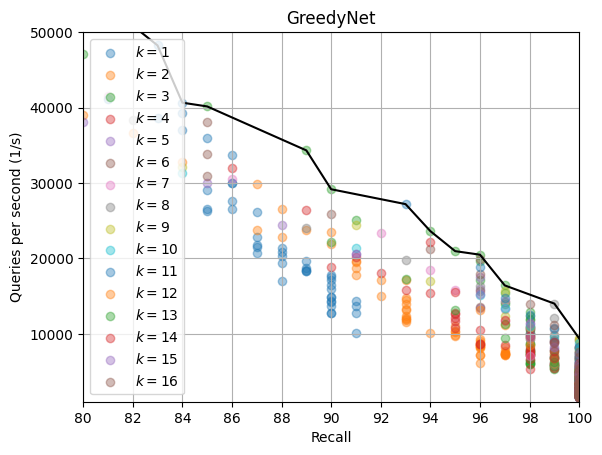

In [26]:
n = data.shape[0]
SC = data[data[:,1] < 2000,0]
QPS = data[data[:,1] < 2000,2]
RECALL = data[data[:,1] < 2000,3]
n = SC.shape[0]
# plt.scatter(RECALL[SC==6], QPS[SC==6], c='red', alpha=0.4, label="S=6")
# plt.scatter(RECALL[SC==7], QPS[SC==7], c='orange', alpha=0.4, label="S=7")
# plt.scatter(RECALL[SC==9], QPS[SC==9], c='blue', alpha=0.4, label="S=9")
# plt.scatter(RECALL[SC==10], QPS[SC==10], c='green', alpha=0.4, label="S=10")
# plt.scatter(RECALL[SC==11], QPS[SC==11], c='purple', alpha=0.4, label="S=11")
for i in range(1, 17):
    plt.scatter(RECALL[SC==i], QPS[SC==i], alpha=0.4, label=f"$k={i}$")
plt.xlim(80, 100)
plt.ylim(10**3, 50000)
# plt.yscale('log')

best_data = []
for i in range(n):
    best = True
    for j in range(n):
        if (QPS[j] > QPS[i]) and (RECALL[j] >= RECALL[i]):
            best = False
            break
    if best:
        best_data.append(data[i])
best_data.sort(key = lambda row: row[3])
best_data = np.array(best_data)
plt.plot(best_data[:,3], best_data[:,2], color='black')
plt.xlabel('Recall')
plt.ylabel('Queries per second (1/s)')
plt.title('GreedyNet')

plt.xticks(np.linspace(80, 100, 11))

plt.grid()
plt.legend()

plt.show()

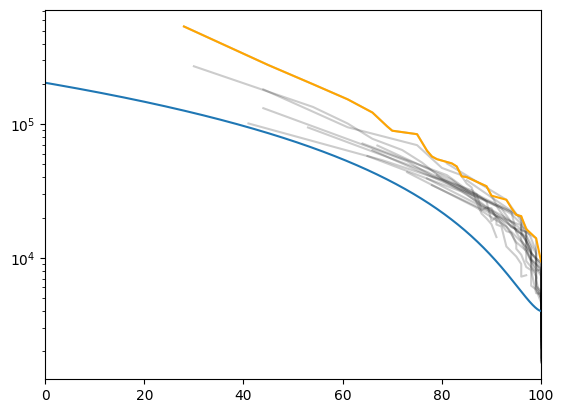

In [6]:
def GetBest(data):
    best_data = []
    n = data.shape[0]
    for i in range(n):
        best = True
        for j in range(n):
            if (QPS[j] > QPS[i]) and (RECALL[j] >= RECALL[i]):
                best = False
                break
        if best:
            best_data.append(data[i])
    best_data.sort(key = lambda row: row[3])
    best_data = np.array(best_data)
    return best_data

for i in range(1, 17):
    cur = GetBest(data[data[:,0] == i])
    plt.plot(cur[:,3], cur[:,2], alpha=0.2, color='black')
cur = GetBest(data)
plt.plot(cur[:,3], cur[:,2], color='orange')
plt.yscale('log')
X = np.linspace(0, 1, 1000)
plt.plot(100*(1-X), (X**1.5) * 2e5 + 4e3)
plt.xlim(0, 100)
plt.show()

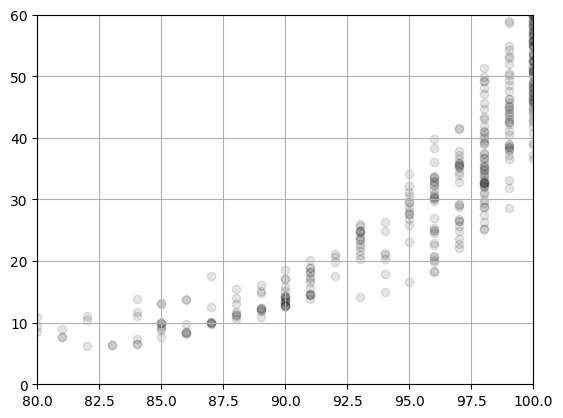

In [7]:
RECALL = data[:,3]
CMPCNT = data[:,4]
plt.scatter(RECALL, CMPCNT, c='black', alpha=0.1)
plt.xlim(80, 100)
plt.ylim(0, 60)
plt.grid()
plt.show()

In [22]:
data_hnsw = os.popen('../build/tann test hnsw ../datasets/siftsmall-128-euclidean.hdf5').read()
data_hnsw = np.array(json.loads(data_hnsw))

Try to read /test [I16]... --> size: 100x128
Try to read /train [I16]... --> size: 10000x128
[Linear Search]
Build time: 42 ns
Query time: 18057219 ns
[HSNW, efconstruct=5, M=10] => build time: 108948152 ns
[HSNW, efconstruct=5, M=20] => build time: 115332753 ns
[HSNW, efconstruct=5, M=40] => build time: 207825714 ns
[HSNW, efconstruct=5, M=50] => build time: 251489533 ns
[HSNW, efconstruct=10, M=10] => build time: 64385645 ns
[HSNW, efconstruct=10, M=20] => build time: 110106450 ns
[HSNW, efconstruct=10, M=40] => build time: 201832151 ns
[HSNW, efconstruct=10, M=50] => build time: 254331400 ns
[HSNW, efconstruct=20, M=10] => build time: 108436295 ns
[HSNW, efconstruct=20, M=20] => build time: 120273781 ns
[HSNW, efconstruct=20, M=40] => build time: 213124627 ns
[HSNW, efconstruct=20, M=50] => build time: 251452088 ns
[HSNW, efconstruct=50, M=10] => build time: 244975668 ns
[HSNW, efconstruct=50, M=20] => build time: 246645282 ns
[HSNW, efconstruct=50, M=40] => build time: 246398308 ns

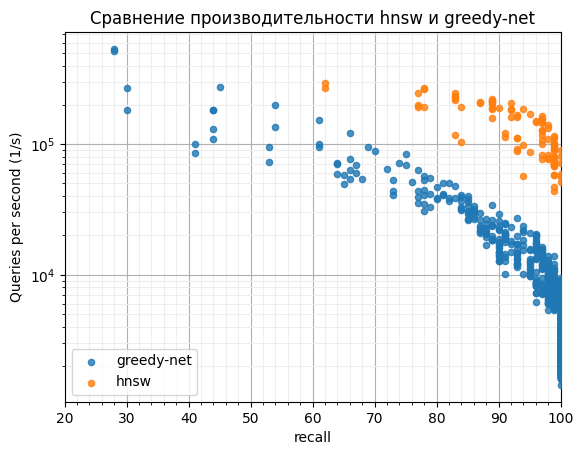

In [23]:
plt.xlim(0, 100)
# plt.ylim(0, 70000)
plt.yscale('log')
plt.minorticks_on()
plt.grid(which='minor', color='#EEE')
plt.grid(which='major')
plt.scatter(data[:,3], data[:,2], label='greedy-net', alpha=0.8, s=20, zorder=10)
plt.scatter(data_hnsw[:,4], data_hnsw[:,3], label='hnsw', alpha=0.8, s=20, zorder=10)
plt.legend(loc='lower left')
plt.xlabel('recall')
plt.xlim(20, 100)
plt.ylabel('Queries per second (1/s)')
plt.title('Сравнение производительности hnsw и greedy-net')
plt.show()

/tmp/ipykernel_41218/3776038593.py:13: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 500)


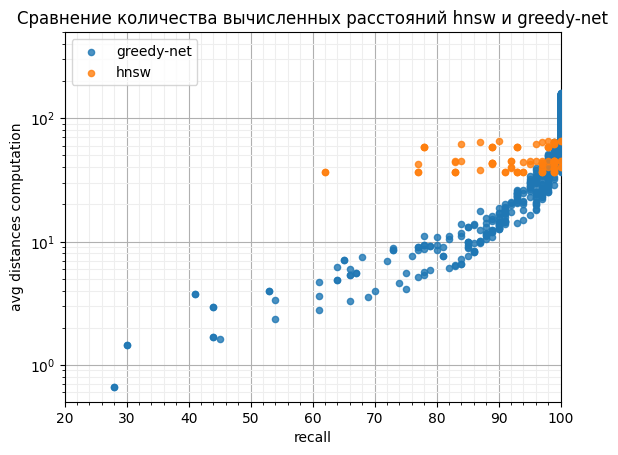

In [24]:
plt.xlim(0, 100)
# plt.ylim(0, 70000)
plt.yscale('log')
plt.minorticks_on()
plt.grid(which='minor', color='#EEE')
plt.grid(which='major')
plt.scatter(data[:,3], data[:,4], label='greedy-net', alpha=0.8, s=20, zorder=10)
plt.scatter(data_hnsw[:,4], data_hnsw[:,5], label='hnsw', alpha=0.8, s=20, zorder=10)
plt.legend(loc='upper left')
plt.xlabel('recall')
plt.xlim(20, 100)
plt.ylabel('avg distances computation')
plt.ylim(0, 500)
plt.title('Сравнение количества вычисленных расстояний hnsw и greedy-net')
plt.show()